# Integrating the moment equations - mRNA

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [11]:
import pickle
import dill # Library that we will use to export lambdify functions

# Our numerical workhorses
import numpy as np
import scipy as sp

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

# Numerically integrating the moment equations.

In this notebook we will numerically integrate the differential equations for the mRNA distribution moments for the two-state unregulated promoter.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and try to solve them.

### Zeroth moment 
In order to solve for the two- and three-state promoter we have two equations to use
$$
\bb{1} = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ for the unregulatd promoter and $u = (1, 1, 1)$ for the regulated case and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
{d \over dt} \ee{\bb{m}^0} = \mathbf{K}_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's now define this system.

In [37]:
def dm0dt(m0, t, Kmat):
    '''
    function to integrate dm0 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m0 : array-like.
        Array containing the zeroth moment of the states of the
        promoter.
        m0[0] = m0_P (RNAP bound)
        m0[1] = m0_E (Empty promoter)
        m0[2] = m0_R (Repressor bound) NOTE: This state is optional
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Returns
    -------
    dm0 / dt
    '''
    # Compute the master equation
    return np.dot(Kmat, m0)

### First moment two-state promoter

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
{d \over dt}\ee{\bb{m}^1} = 
\left( \mathbf{K}_m - \mathbf{\Gamma}_m  \right)\ee{\bb{m}^1}
             + \mathbf{R}_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's define a function to compute this system.

**Note:** Since the solution of the first moment depends on the solution of the zeroth moment the function will call the zeroth moment function and the system will solve all equations sumultaneously.

In [72]:
def dm1dt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm1 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth and first moment of the states of the 
        promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (RNAP bound)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    dm0/dt and dm1/dt
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, dm1dt_eq) 

### Second moment two-state promoter

For the second moment we have an equation of the form
$$
{d\ee{\bb{m}^2} \over dt} = \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define the function to compute the second moment (including the zeroth and first moment again)

In [73]:
def dm2dt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm2 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth and first moment of the states of the 
        promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    dm0/dt and dm1/dt
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, np.append(dm1dt_eq, dm2dt_eq))

Let's define the parameters necessary for the unregulated promoter.

In [74]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

kp_on = par_UV5['kp_on']
kp_off = par_UV5['kp_off']
rm = par_UV5['rm']
gm = par_UV5['gm']

# Define time on which to perform integration
t = np.linspace(0, 0.4, 101)

# Define initial conditions
m0_init = [0.5, 0.5]

Now we will define the state transition matrix $\mathbf{K}^u$, the mRNA production matrix $\mathbf{R}^u_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^u_m$.

In [48]:
# Define the rate constant matrix
Kmat_unreg = np.array([[-kp_off, kp_on], 
                       [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = np.array([[rm, 0], 
                       [0, 0]])
# Define the degradation matrix
Gmat_unreg = np.array([[gm, 0],
                       [0, gm]])

Having this in hand we can now numerically solve the equations.

In [49]:
# Numerically integrate equations
m0_sol = sp.integrate.odeint(dm0dt, m0_init, t, args=(Kmat_unreg,))

Let's plot the solution!

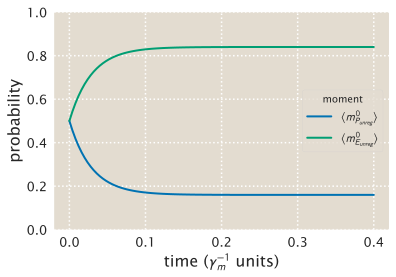

In [50]:
#Plot the solution
plt.plot(t, m0_sol[:, 0], label=r'$\langle m^0_{P_{unreg}}\rangle$')
plt.plot(t, m0_sol[:, 1], label=r'$\langle m^0_{E_{unreg}}\rangle$')

plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel('probability')
plt.ylim([0, 1])
plt.legend(title='moment', fontsize=12)

In [63]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]

# Numerically integrate equations
m1_sol = sp.integrate.odeint(dm1dt, m0_init + m1_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

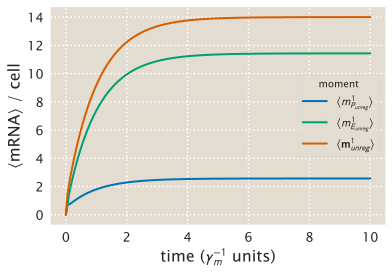

In [68]:
#Plot the solution
plt.plot(t, m1_sol[:, 2], label=r'$\langle m^1_{P_{unreg}}\rangle$')
plt.plot(t, m1_sol[:, 3], label=r'$\langle m^1_{E_{unreg}}\rangle$')
# Plot the global moment (i.e. the sum of the individual moments)
plt.plot(t, np.sum(m1_sol[:, [2,3]], axis=1), 
         label=r'$\langle \mathbf{m}^1_{unreg}\rangle$')

plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel(r'$\left\langle\right.$mRNA$\left.\right\rangle$ / cell')
_ = plt.legend(title='moment', fontsize=12)

In [75]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]

# Numerically integrate equations
m2_sol = sp.integrate.odeint(dm2dt, m0_init + m1_init + m2_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

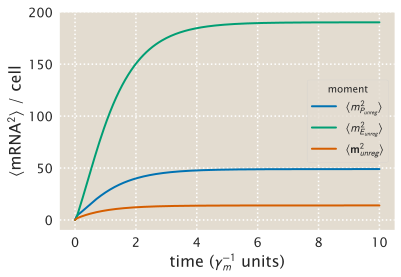

In [76]:
#Plot the solution
plt.plot(t, m2_sol[:, 4], label=r'$\langle m^2_{P_{unreg}}\rangle$')
plt.plot(t, m2_sol[:, 5], label=r'$\langle m^2_{E_{unreg}}\rangle$')
# Plot the global moment (i.e. the sum of the individual moments)
plt.plot(t, np.sum(m1_sol[:, [2,3]], axis=1), 
         label=r'$\langle \mathbf{m}^2_{unreg}\rangle$')

plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel(r'$\left\langle\right.$mRNA$^2\left.\right\rangle$ / cell')
_ = plt.legend(title='moment', fontsize=12)

---

In [ ]:
dm2dt_unreg = sympy.Matrix([m.diff() for m in m2_unreg])
dm2dt_rhs = (Kmat_unreg - 2 * Gmat_unreg)* sympy.Matrix(m2_unreg) +\
            (2 * Rmat_unreg + Gmat_unreg) * sympy.Matrix(m1_unreg) +\
            Rmat_unreg * sympy.Matrix(m0_unreg)

sys = [sympy.Eq(dm2dt_unreg[i], dm2dt_rhs[i]) for i in range(2)]
sys

As with the first moment we will define a differential equation for the global moment $\ee{\bb{m}^2}$.

In [ ]:
# Sum both differential equations and ractor terms
dmm2dt_rhs = sum(dm2dt_rhs).collect(m2_unreg[0]).\
                            collect(m2_unreg[1]).\
                            collect(m1_unreg[0]).\
                            collect(m1_unreg[1]).\
                            collect(gm).\
                            subs(2 * sum(m2_unreg), 2 * mm2_unreg)

# Print differential equation for global moment
sympy.Eq(mm2_unreg.diff(), dmm2dt_rhs)

This indicates that without knowing the individual first moments (rather than the global moment as we solved it) we cannot get to the second moment. This is caused because of the asymmetry of the $\bb{R}_m^u$ matrix.